In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import georinex as gr
import xarray as xr

import pathlib

In [2]:
week = 2109

def mask_zeros(x):
    return x.where(x != 0)

In [3]:
def load(path):
    x = gr.load(path)
    params = ['BGDe5a', 'BGDe5b', 'SVclockBias', 'DataSrc']
    return x[params].sel(sv = [sv for sv in x.sv.values if sv.startswith('E')])

data = pathlib.Path('data')
rnx = xr.concat((load(r) for r in data.glob('*.rnx')), dim = 'time')

In [4]:
gal_sv = sorted({sv[:3] for sv in rnx.sv.values if sv.startswith('E') and sv[:3] not in ['E14', 'E18']})

def aliases(svn):
    return [sv for sv in rnx.sv.values if sv.startswith(svn)]

In [5]:
means_e5a = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn))).mean() for svn in gal_sv]
stds_e5a = [1e9*mask_zeros(rnx['BGDe5a'].sel(sv = aliases(svn))).std() for svn in gal_sv]
means_e5b = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn))).mean() for svn in gal_sv]
stds_e5b = [1e9*mask_zeros(rnx['BGDe5b'].sel(sv = aliases(svn))).std() for svn in gal_sv]

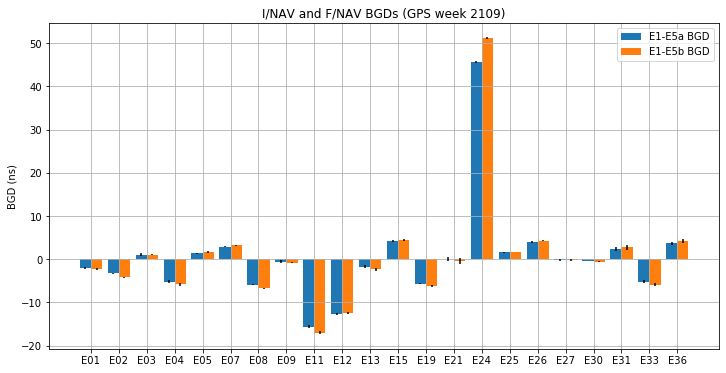

In [6]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.bar(np.arange(len(means_e5a))-0.2, means_e5a, yerr = stds_e5a, width = 0.4)
plt.bar(np.arange(len(means_e5b))+0.2, means_e5b, yerr = stds_e5b, width = 0.4)
plt.xticks(np.arange(len(means_e5a)), gal_sv)
plt.grid()
plt.legend(['E1-E5a BGD', 'E1-E5b BGD'])
plt.title(f'I/NAV and F/NAV BGDs (GPS week {week})')
plt.ylabel('BGD (ns)');

In [7]:
def af0_difference(svn):
    datasrc = rnx['DataSrc'].sel(sv = aliases(svn))
    datasrc = np.int32(datasrc.where(~np.isnan(datasrc), 0).values)
    src_e5a = datasrc & 0x100
    src_e5b = datasrc & 0x200
    af0_e5a = rnx['SVclockBias'].sel(sv = aliases(svn)).where(src_e5a).mean('sv')
    af0_e5b = rnx['SVclockBias'].sel(sv = aliases(svn)).where(src_e5b).mean('sv')
    return af0_e5a - af0_e5b

In [8]:
af0_diffs = [af0_difference(svn) for svn in gal_sv]
af0_diff_means = [1e9*a.mean() for a in af0_diffs]
af0_diff_stds = [1e9*a.std() for a in af0_diffs]

/home/daniel/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


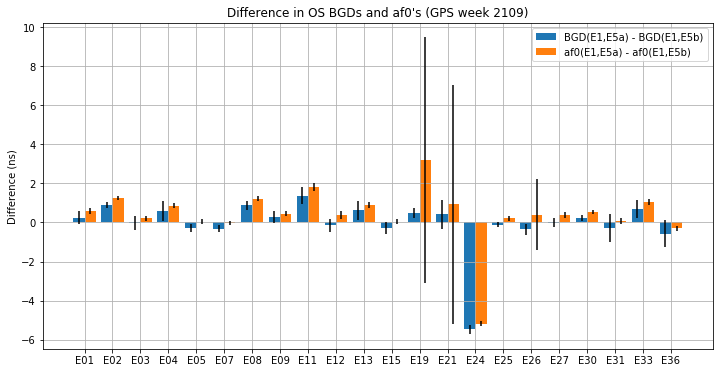

In [9]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.bar(np.arange(len(means_e5a))-0.2, np.array(means_e5a) - np.array(means_e5b),
        yerr = np.sqrt(np.array(stds_e5a)**2 + np.array(stds_e5b)**2), width = 0.4)
plt.bar(np.arange(len(means_e5b))+0.2, np.array(af0_diff_means), yerr = af0_diff_stds, width = 0.4)
plt.xticks(np.arange(len(means_e5a)), gal_sv)
plt.grid()
plt.legend(['BGD(E1,E5a) - BGD(E1,E5b)', 'af0(E1,E5a) - af0(E1,E5b)'])
plt.title(f'Difference in OS BGDs and af0\'s (GPS week {week})')
plt.ylabel('Difference (ns)');

In [10]:
def is_gal(x):
    return len(x) == 3 and x[0] == 'E'

dsb = list()
for p in data.glob('*.BSX'):
    with open(p) as f:
        dsb.extend([l for l in f if l.startswith(' DSB') and is_gal(l.split()[2])])

In [11]:
gal_sv_all = sorted({s.split()[2] for s in dsb})
sigs = ['C5Q', 'C6C', 'C7Q', 'C8Q']

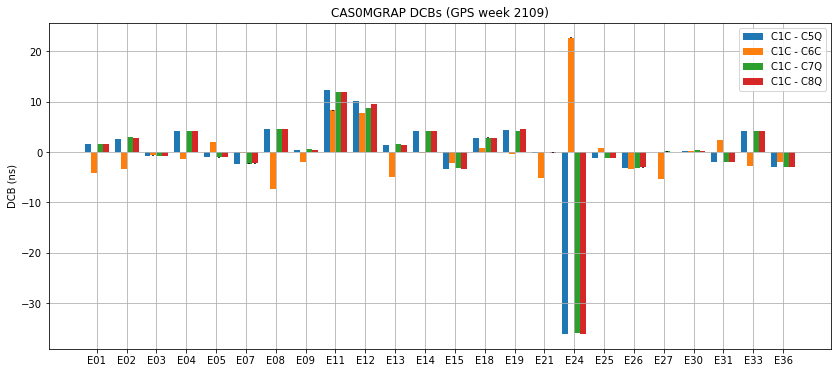

In [12]:
plt.figure(figsize = (14,6), facecolor = 'w')
for j,sig in enumerate(sigs):
    dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb if s.split()[2] == svn and s.split()[4] == sig] for svn in gal_sv_all])
    means = np.average(dat[...,0], axis = -1)
    stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
    plt.bar(np.arange(len(means))-0.2*1.5+j*0.2, means, yerr = stds, width = 0.2)
plt.xticks(np.arange(len(means)), gal_sv_all)
plt.grid()
plt.legend([f'C1C - {sig}' for sig in sigs])
plt.title(f'CAS0MGRAP DCBs (GPS week {week})')
plt.ylabel('DCB (ns)');

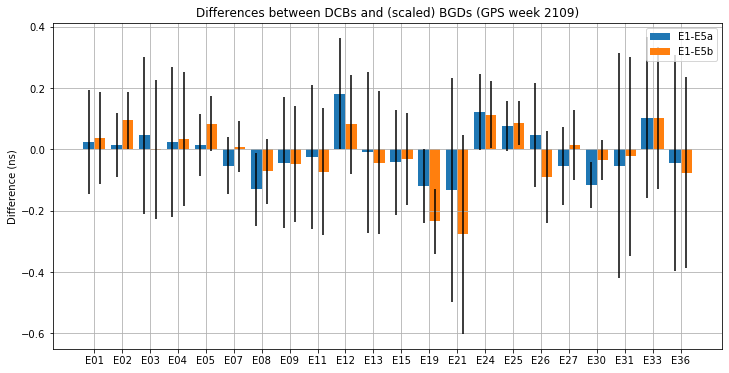

In [13]:
f1 = 1575.42
f2 = 1176.450
f3 = 1207.140

plt.figure(figsize = (12,6), facecolor = 'w')
dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb if s.split()[2] == svn and s.split()[4] == 'C5Q'] for svn in gal_sv])
means = np.average(dat[...,0], axis = -1)
stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
plt.bar(np.arange(len(means))-0.2, means - np.array(means_e5a)*(1-(f1/f2)**2),
        yerr = np.sqrt(stds**2 + np.array(stds_e5a)**2*(1-(f1/f2)**2)**2), width = 0.4)
dat = np.array([[[float(x) for x in s.split()[-2:]] for s in dsb if s.split()[2] == svn and s.split()[4] == 'C7Q'] for svn in gal_sv])
means = np.average(dat[...,0], axis = -1)
stds = np.sqrt(np.sum(dat[...,1]**2, axis = -1))/dat.shape[1]
plt.bar(np.arange(len(means))+0.2, means - np.array(means_e5b)*(1-(f1/f3)**2),
        yerr = np.sqrt(stds**2 + np.array(stds_e5a)**2*(1-(f1/f3)**2)**2), width = 0.4)
plt.xticks(np.arange(len(means)), gal_sv)
plt.grid()
plt.legend(['E1-E5a', 'E1-E5b'])
plt.title(f'Differences between DCBs and (scaled) BGDs (GPS week {week})')
plt.ylabel('Difference (ns)');